In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu

import gymnax
import optax
import equinox as eqx

from  functools import partial
import matplotlib.pyplot as plt

from models import NeuralNetwork
from reinforce import train_step, visualize_trajectory

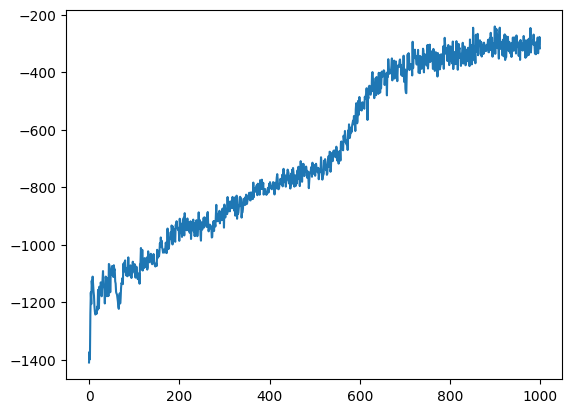

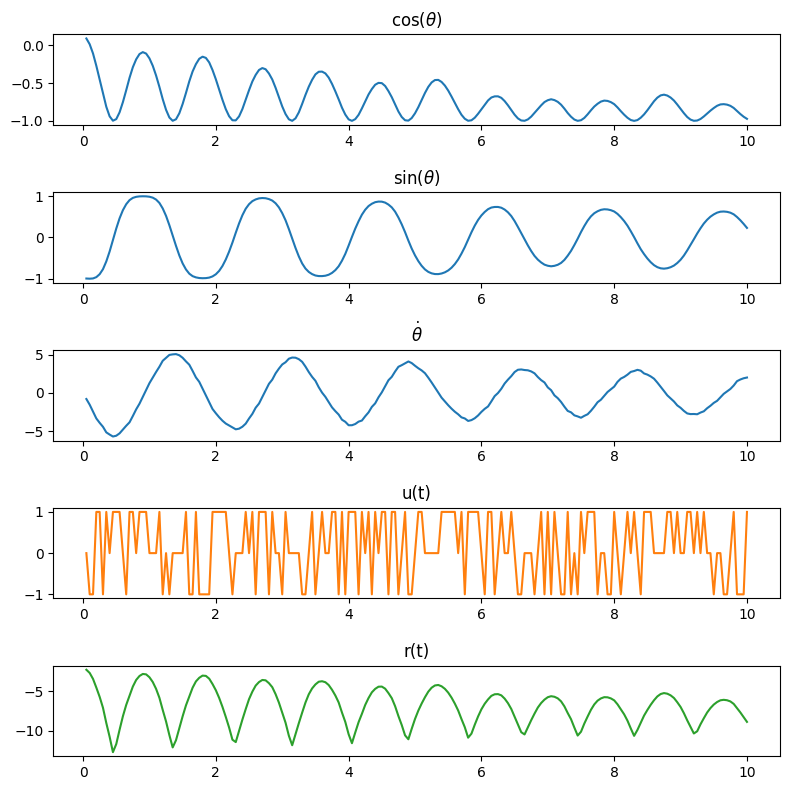

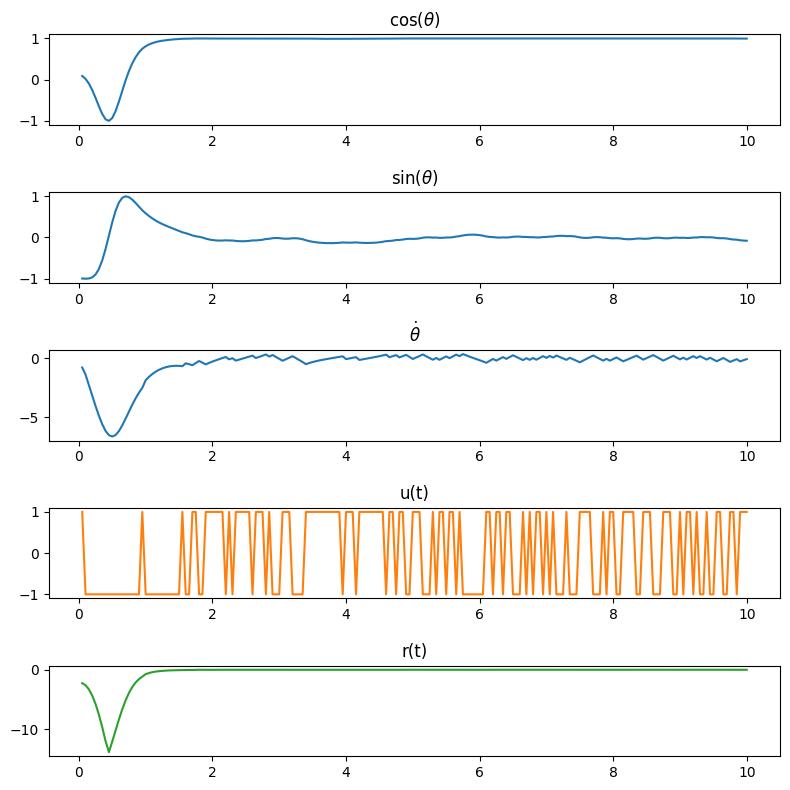

In [2]:
key_policy, key_train, key_visualize = jr.split(jr.PRNGKey(SEED), 3)

# Get environment params
env, env_params = gymnax.make('Pendulum-v1')
# Make model
policy = NeuralNetwork(input_size=3, output_size=3, width_size=65, depth=1, key=key_policy)
# Split params
start_params, static = eqx.partition(policy, eqx.is_array)
# Training parameters
learning_rate = 5e-3
n_runs = 1000
n_batches = 64
# Setup optimizer
optim = optax.adam(learning_rate)
opt_state = optim.init(start_params)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_debug_infs", True)

keys_train = jr.split(key_train, n_runs)
(trained_params, _), history = jax.lax.scan(
    partial(
        train_step,
        model_static=static,
        env_params=env_params,
        optimizer=optim,
        n_batches=n_batches,
    ),
    (start_params, opt_state),
    keys_train
)

plt.plot(history)
visualize_trajectory(eqx.combine(start_params, static), env, env_params, key=key_visualize)
visualize_trajectory(eqx.combine(trained_params, static), env, env_params, key=key_visualize)

In [3]:
from helpers import rollout_parallel
def select_action_mpc(key, horizon, rollout_batch_size, *, 
                      model_params, model_static, env_params):

    # Get trajectories
    keys_rollout = jr.split(key, rollout_batch_size)
    _, _, rewardss, _, _= rollout_parallel(keys_rollout, model_params, model_static, env_params)

    # Selection criteria
    final_rewards = rewardss[:, -1]
    
